## Identification Rate Metric

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

**Для подсчета метрик, то вам нужно разбить данные на query и distractors самим.**

Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

## План заданий

* Правильно разбить датасет на query и distractors
* Реализовать метрику и пройти все тесты
* Подгрузить все модели, обученные на разных лоссах и сравнить их метрики

## Шаблон кода для Identificaton rate metric (TPR@FPR)

In [40]:
import matplotlib.pyplot as plt
import torch
import matplotlib.patches as patches
import random
import pandas
import numpy as np
import seaborn
import cv2
import os
from time import time
from torch import nn
from tqdm import tqdm
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import functional as TF
from torchvision import transforms
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import ToPILImage
import torchvision.models as models
from itertools import combinations
from torch.nn.functional import cosine_similarity
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/CelebA"
landmarks_path = f"{base_path}/list_landmarks_align_celeba.txt"
identity_path  = f"{base_path}/identity_CelebA.txt"
partition_path = f"{base_path}/list_eval_partition.txt"
landmarks_df = pd.read_csv(landmarks_path, sep='\s+', skiprows=1)
filenames = [(str(i + 1).zfill(6) + ".jpg") for i in range(len(landmarks_df))]
landmarks_df.insert(0, "filename", filenames)

identity_df  = pd.read_csv(identity_path, sep='\s+', header=None, names=["filename", "identity"])
partition_df = pd.read_csv(partition_path, sep='\s+', header=None, names=["filename", "partition"])
df = identity_df.merge(landmarks_df, on="filename").merge(partition_df, on="filename")

print(df.head())

Mounted at /content/drive
     filename  identity  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
0  000001.jpg      2880         69        109         106         113      77   
1  000002.jpg      2937         69        110         107         112      81   
2  000003.jpg      8692         76        112         104         106     108   
3  000004.jpg      5805         72        113         108         108     101   
4  000005.jpg      9295         66        114         112         112      86   

   nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  partition  
0     142           73          152           108           154          0  
1     135           70          151           108           153          0  
2     128           74          156            98           158          0  
3     138           71          155           101           151          0  
4     119           71          147           104           150          0  


In [20]:
df_train = df[df["partition"] == 0].reset_index(drop=True)
df_val   = df[df["partition"] == 1].reset_index(drop=True)
df_test  = df[df["partition"] == 2].reset_index(drop=True)

print(f"Train: {len(df_train)}")
print(f"Val:   {len(df_val)}")
print(f"Test:  {len(df_test)}")

Train: 162770
Val:   19867
Test:  19962


In [21]:
train_df_small = df_train.iloc[:7500].reset_index(drop=True)
val_df_small   = df_val.iloc[:1500].reset_index(drop=True)
used_ids = pd.concat([train_df_small, val_df_small])['identity'].unique()
available_df = df[~df['identity'].isin(used_ids)].copy()

top_identities = df['identity'].value_counts().head(500).index.tolist()
classifier_df = df[df['identity'].isin(top_identities)].reset_index(drop=True)

print(f"Выбрано {len(top_identities)} identity, всего {len(classifier_df)} изображений")
print("Фото на одного человека (min / max):",
      classifier_df['identity'].value_counts().min(),
      "/",
      classifier_df['identity'].value_counts().max())

Выбрано 500 identity, всего 15038 изображений
Фото на одного человека (min / max): 30 / 35


In [22]:
excluded_ids = set(used_ids).union(set(top_identities))
remaining_df = df[~df['identity'].isin(excluded_ids)].copy()
print("Осталось уникальных identity:", remaining_df['identity'].nunique())
print("Мин/макс фото на identity:",
      remaining_df['identity'].value_counts().min(),
      '/',
      remaining_df['identity'].value_counts().max())

Осталось уникальных identity: 4645
Мин/макс фото на identity: 1 / 30


In [23]:
from collections import Counter
import random

# Считаем количество фото на identity
id_counts = remaining_df['identity'].value_counts()

# Кандидаты для query (≥3 фото)
query_candidates = id_counts[id_counts >= 3].index.tolist()

# Остальные — кандидаты для distractors
distractor_candidates = id_counts[~id_counts.index.isin(query_candidates)].index.tolist()
print(f"Доступно distractor_candidates: {len(distractor_candidates)}")

Доступно distractor_candidates: 329


In [24]:
# Берём всех возможных distractor identity
distractor_ids = distractor_candidates  # 339 штук

# Чтобы не было дисбаланса, уменьшим query тоже до, например, 50
query_ids = random.sample(query_candidates, k=50)

print(f"Выбрано {len(query_ids)} identity для query и {len(distractor_ids)} для distractors")

Выбрано 50 identity для query и 329 для distractors


In [25]:
query_df = remaining_df[remaining_df['identity'].isin(query_ids)].reset_index(drop=True)
distractor_df = remaining_df[remaining_df['identity'].isin(distractor_ids)].reset_index(drop=True)

In [12]:
# Распакуем во временную папку
!unzip -q /content/drive/MyDrive/CelebA/img_align_celeba.zip -d /content/img_celeba


In [13]:
img_dir = "/content/img_celeba/img_align_celeba"

In [26]:
class CelebAHeatmapAugmented(Dataset):
    def __init__(self, img_dir, landmarks_df, image_size=256, heatmap_size=64, sigma=1.5):
        self.img_dir = img_dir
        self.landmarks_df = landmarks_df
        self.image_size = image_size
        self.heatmap_size = heatmap_size
        self.sigma = sigma

    def __len__(self):
        return len(self.landmarks_df)

    def __getitem__(self, idx):
        row = self.landmarks_df.iloc[idx]
        fname = row['filename'].strip()
        img_path = os.path.join(self.img_dir, fname)

        image = Image.open(img_path).convert('RGB')
        orig_w, orig_h = image.size

        keypoints = np.array([
            [row['lefteye_x'], row['lefteye_y']],
            [row['righteye_x'], row['righteye_y']],
            [row['nose_x'], row['nose_y']],
            [row['leftmouth_x'], row['leftmouth_y']],
            [row['rightmouth_x'], row['rightmouth_y']]
        ], dtype=np.float32)

        scale_x = self.image_size / orig_w
        scale_y = self.image_size / orig_h
        keypoints *= [scale_x, scale_y]
        image = image.resize((self.image_size, self.image_size))
        image_np = np.array(image)

        angle = random.uniform(-45, 45)
        scale = random.uniform(0.9, 1.1)
        tx = random.uniform(-0.05, 0.05) * self.image_size
        ty = random.uniform(-0.05, 0.05) * self.image_size
        center = (self.image_size / 2, self.image_size / 2)

        M = cv2.getRotationMatrix2D(center, angle, scale)
        M[:, 2] += [tx, ty]

        # трансформация изображения
        image_affine = cv2.warpAffine(image_np, M, (self.image_size, self.image_size), borderMode=cv2.BORDER_REFLECT)

        # трансформация keypoints
        keypoints_aug = np.hstack([keypoints, np.ones((5, 1))]) @ M.T
        keypoints_aug = np.clip(keypoints_aug, 0, self.image_size - 1)

        # преобразование в тензор
        image_tensor = TF.to_tensor(Image.fromarray(image_affine))

        # heatmaps
        heatmaps = self.generate_heatmaps(keypoints_aug)

        return image_tensor, torch.tensor(heatmaps, dtype=torch.float32)

    def generate_heatmaps(self, keypoints):
        hms = np.zeros((len(keypoints), self.heatmap_size, self.heatmap_size), dtype=np.float32)
        for i, (x, y) in enumerate(keypoints):
            x = x * self.heatmap_size / self.image_size
            y = y * self.heatmap_size / self.image_size
            xx, yy = np.meshgrid(np.arange(self.heatmap_size), np.arange(self.heatmap_size))
            hms[i] = np.exp(-((xx - x)**2 + (yy - y)**2) / (2 * self.sigma**2))
        return hms

In [27]:
query_dataset = CelebAHeatmapAugmented(
    img_dir,
    landmarks_df=query_df,
    image_size=256,
    heatmap_size=64,
    sigma=2
)

distractor_dataset = CelebAHeatmapAugmented(
    img_dir,
    landmarks_df=distractor_df,
    image_size=256,
    heatmap_size=64,
    sigma=2
)


In [28]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        mid_channels = out_channels // 2

        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, mid_channels, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(mid_channels)

        self.conv2 = nn.Conv2d(mid_channels, mid_channels, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mid_channels)

        self.conv3 = nn.Conv2d(mid_channels, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        skip = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + skip)

class Hourglass(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.channels = channels

        self.skip = Residual(channels, channels)
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            Residual(channels, channels)
        )

        if depth > 1:
            self.inner = Hourglass(depth - 1, channels)
        else:
            self.inner = Residual(channels, channels)

        self.up = Residual(channels, channels)

    def forward(self, x):
        skip = self.skip(x)
        x = self.down(x)
        x = self.inner(x)
        x = self.up(F.interpolate(x, scale_factor=2, mode='nearest'))
        return x + skip

class HourglassBlock(nn.Module):
    def __init__(self, depth, channels, num_keypoints):
        super().__init__()
        self.hourglass = Hourglass(depth, channels)
        self.res = Residual(channels, channels)
        self.out_heatmap = nn.Conv2d(channels, num_keypoints, kernel_size=1)

        # intermediate supervision:
        self.out_feature = nn.Conv2d(channels, channels, kernel_size=1)
        self.out_heatmap_to_feat = nn.Conv2d(num_keypoints, channels, kernel_size=1)

    def forward(self, x):
        hg = self.hourglass(x)
        feat = self.res(hg)
        heatmap = self.out_heatmap(feat)
        feat_next = x + self.out_feature(feat) + self.out_heatmap_to_feat(heatmap)
        return heatmap, feat_next

class StackedHourglassNet(nn.Module):
    def __init__(self, num_stacks, num_blocks, channels, num_keypoints):
        super().__init__()
        self.pre = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            Residual(64, 128),
            nn.MaxPool2d(2),
            Residual(128, 128),
            Residual(128, channels)
        )

        self.stacks = nn.ModuleList([
            HourglassBlock(num_blocks, channels, num_keypoints)
            for _ in range(num_stacks)
        ])

    def forward(self, x):
        x = self.pre(x)
        outputs = []

        for stack in self.stacks:
            heatmap, x = stack(x)
            outputs.append(heatmap)

        return outputs  # список [B, num_keypoints, 64, 64]

In [29]:
hourglass = StackedHourglassNet(num_stacks=2, num_blocks=4, channels=128, num_keypoints=5)
hourglass.load_state_dict(torch.load("/content/shg_amazing.pth", map_location='cpu'))
hourglass = hourglass.to(device).eval()

In [30]:
def align_and_save_faces_with_labels(dataset, labels, model, save_dir, device='cuda', output_size=(112, 112), limit=None):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    to_pil = ToPILImage()

    def heatmap_to_coords(hms):
        coords = []
        for hm in hms:
            y, x = np.unravel_index(np.argmax(hm), hm.shape)
            coords.append([x * 4, y * 4])  # 64 → 256
        return np.array(coords, dtype=np.float32)

    standard = np.array([
        [30.2946, 51.6963],
        [65.5318, 51.5014],
        [48.0252, 71.7366],
        [33.5493, 92.3655],
        [62.7299, 92.2041]
    ], dtype=np.float32)

    if output_size[0] != 112:
        standard *= (output_size[0] / 112)

    count = 0
    for i in range(len(dataset)):
        if limit and count >= limit:
            break

        try:
            img_tensor, _ = dataset[i]
            identity = labels[i]
            person_dir = os.path.join(save_dir, str(identity))
            os.makedirs(person_dir, exist_ok=True)

            img_pil = to_pil(img_tensor.cpu())
            input_tensor = T.Resize((256, 256))(img_pil)
            input_tensor = T.ToTensor()(input_tensor).unsqueeze(0).to(device)

            with torch.no_grad():
                pred_heatmap = model(input_tensor)[-1][0].cpu().numpy()

            pred_pts = heatmap_to_coords(pred_heatmap)
            M = cv2.estimateAffinePartial2D(pred_pts, standard, method=cv2.LMEDS)[0]
            img_cv = np.array(img_pil.convert('RGB'))
            aligned = cv2.warpAffine(img_cv, M, output_size, borderValue=0)

            filename = os.path.join(person_dir, f"aligned_{count:04d}.jpg")
            Image.fromarray(aligned).save(filename)
            count += 1

        except Exception as e:
            print(f"[SKIP] Ошибка на индексе {i}: {e}")

    print(f"Сохранено {count} лиц в {save_dir} по папкам identity")


In [31]:
align_and_save_faces_with_labels(
    dataset=query_dataset,
    labels=query_df['identity'].tolist(),
    model=hourglass,
    save_dir='aligned_eval/query',
    device=device,
    output_size=(112, 112)
)

align_and_save_faces_with_labels(
    dataset=distractor_dataset,
    labels=distractor_df['identity'].tolist(),
    model=hourglass,
    save_dir='aligned_eval/distractors',
    device=device,
    output_size=(112, 112)
)

Сохранено 751 лиц в aligned_eval/query по папкам identity
Сохранено 617 лиц в aligned_eval/distractors по папкам identity


In [32]:
import shutil
import os
from glob import glob

def collect_aligned_paths_and_labels(root_dir):
    """
    Собирает все пути к .jpg файлам и соответствующие identity из поддиректорий
    :param root_dir: путь до папки (например, aligned_eval/query)
    :return: (paths, labels)
    """
    image_paths = glob(os.path.join(root_dir, "*", "*.jpg"))
    labels = [os.path.basename(os.path.dirname(p)) for p in image_paths]
    return image_paths, labels

shutil.make_archive("aligned_eval_query", "zip", "aligned_eval/query")
shutil.make_archive("aligned_eval_distractors", "zip", "aligned_eval/distractors")

query_paths, query_labels = collect_aligned_paths_and_labels("aligned_eval/query")
distractor_paths, distractor_labels = collect_aligned_paths_and_labels("aligned_eval/distractors")

print(f"Query: {len(query_paths)} изображений, {len(set(query_labels))} identity")
print(f"Distractors: {len(distractor_paths)} изображений, {len(set(distractor_labels))} identity")

Query: 1660 изображений, 98 identity
Distractors: 617 изображений, 329 identity


In [45]:
from collections import defaultdict
query_dict = defaultdict(list)
for path, label in zip(query_paths, query_labels):
    query_dict[label].append(path)

In [33]:
import matplotlib.pyplot as plt
from PIL import Image

def show_faces_grouped_by_identity(image_paths, labels, n_ids=5, images_per_id=4, title=""):
    """
    Показывает n_ids строк, по images_per_id изображений в каждой, сгруппированных по identity
    """
    from collections import defaultdict

    # Сгруппируем пути по identity
    id_to_paths = defaultdict(list)
    for path, label in zip(image_paths, labels):
        id_to_paths[label].append(path)

    selected_ids = random.sample(list(id_to_paths.keys()), k=min(n_ids, len(id_to_paths)))

    plt.figure(figsize=(images_per_id * 2.5, n_ids * 2.5))

    for row_idx, identity in enumerate(selected_ids):
        paths = id_to_paths[identity]
        samples = random.sample(paths, k=min(images_per_id, len(paths)))
        for col_idx, img_path in enumerate(samples):
            plt_idx = row_idx * images_per_id + col_idx + 1
            plt.subplot(n_ids, images_per_id, plt_idx)
            img = Image.open(img_path)
            plt.imshow(img)
            if col_idx == 0:
                plt.ylabel(f"id: {identity}", fontsize=10)
            plt.axis("off")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()



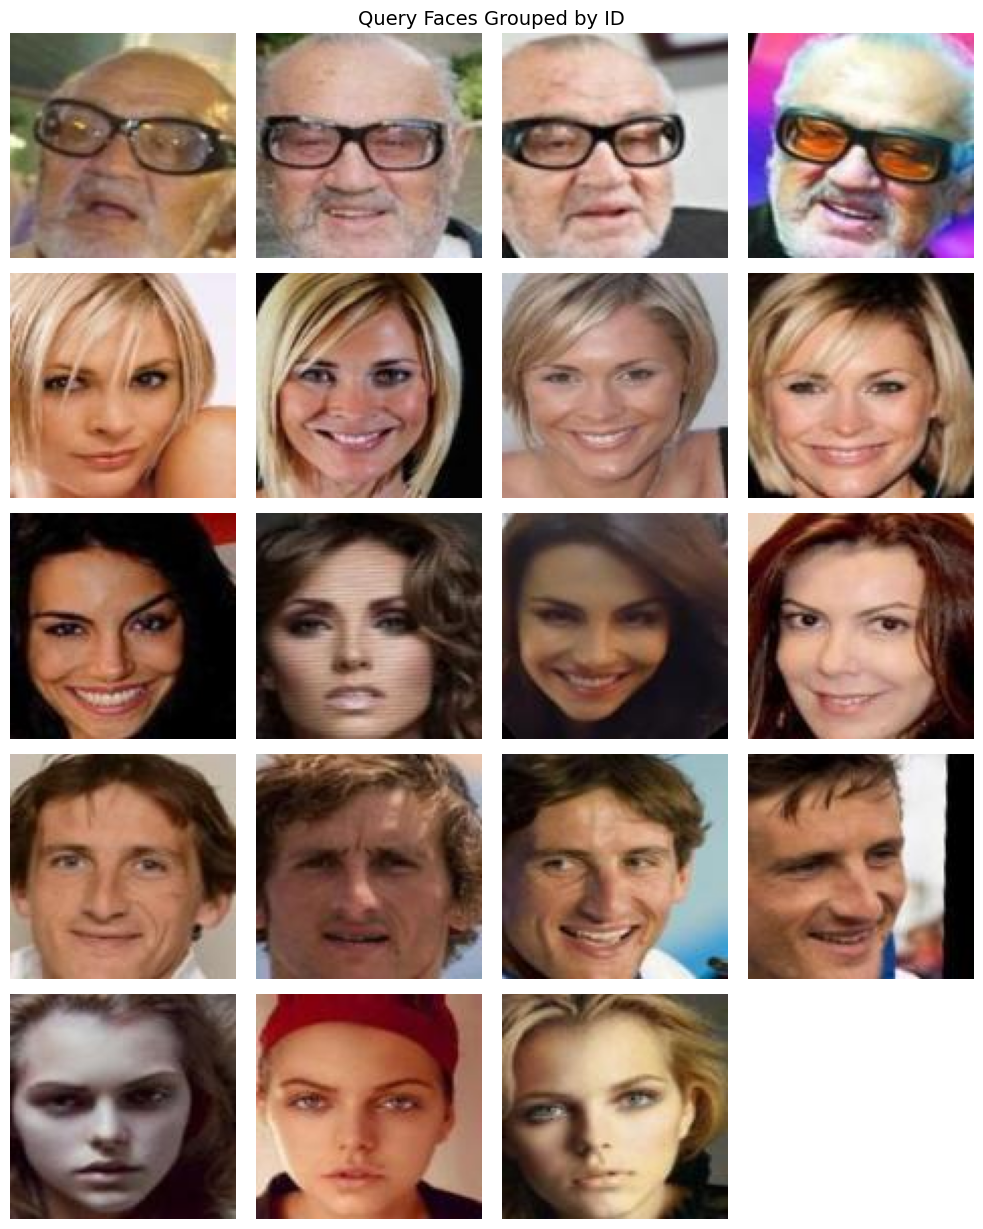

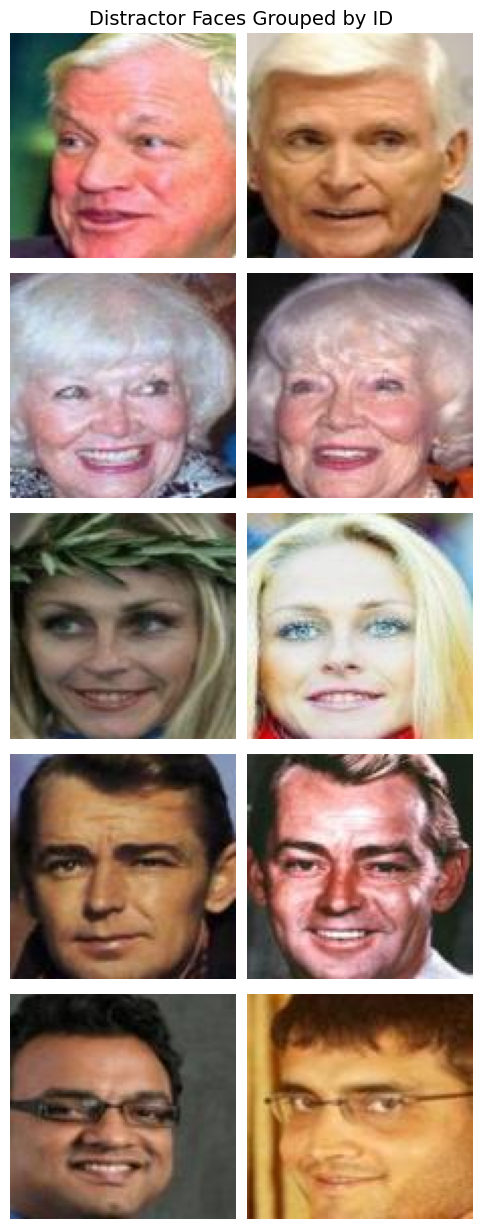

In [36]:
show_faces_grouped_by_identity(query_paths, query_labels, n_ids=5, images_per_id=4, title="Query Faces Grouped by ID")
show_faces_grouped_by_identity(distractor_paths, distractor_labels, n_ids=5, images_per_id=2, title="Distractor Faces Grouped by ID")



In [37]:
from PIL import Image
import torchvision.transforms as T
import torch.nn.functional as F
preprocess = T.Compose([
    T.Resize((112, 112)),
    T.ToTensor(),
    T.Normalize([0.5]*3, [0.5]*3)
])

In [38]:
def compute_embeddings(model, images_list):
    model.eval()
    embeddings = []

    with torch.no_grad():
        for path in images_list:
            img = Image.open(path).convert('RGB')
            x = preprocess(img).unsqueeze(0).to(device)  # shape: (1, 3, 112, 112)
            emb = model(x)
            emb = F.normalize(emb, dim=1)
            embeddings.append(emb.squeeze(0).cpu())

    return embeddings  # list of tensors

In [41]:
# Создаём модель CE
ce_model = models.resnet50(pretrained=False)
ce_model.fc = nn.Sequential(
    nn.Linear(ce_model.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 500)  # финальный слой с bias
)
ce_model.load_state_dict(torch.load("resnet_ce_best.pth")['model_state'])
ce_model = ce_model.to(device).eval()

In [42]:
query_embeddings = compute_embeddings(ce_model, query_paths)
distractors_embeddings = compute_embeddings(ce_model, distractor_paths)

In [47]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    """
    compute cosine similarities between positive pairs from query (stage 1)
    params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
    output:
    list of floats: similarities between embeddings corresponding
                    to the same people from query list
    """
    path_to_emb = dict(zip(query_img_names, query_embeddings))
    sims = []

    for class_id, img_list in query_dict.items():
        for img1, img2 in combinations(img_list, 2):
            emb1 = path_to_emb[img1]
            emb2 = path_to_emb[img2]

            if not isinstance(emb1, torch.Tensor):
                emb1 = torch.tensor(emb1, dtype=torch.float32)
            if not isinstance(emb2, torch.Tensor):
                emb2 = torch.tensor(emb2, dtype=torch.float32)

            sim = cosine_similarity(emb1.unsqueeze(0), emb2.unsqueeze(0)).item()
            sims.append(sim)

    return sims

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding
                      to different people from query list
    '''
    """
    Косинусные похожести между отрицательными парами внутри query
    """
    path_to_emb = dict(zip(query_img_names, query_embeddings))
    sims = []

    all_classes = list(query_dict.keys())

    for i in range(len(all_classes)):
        for j in range(i+1, len(all_classes)):
            class_i = query_dict[all_classes[i]]
            class_j = query_dict[all_classes[j]]

            for img_i in class_i:
                for img_j in class_j:
                    emb_i = path_to_emb[img_i]
                    emb_j = path_to_emb[img_j]
                    if not isinstance(emb_i, torch.Tensor):
                        emb_i = torch.tensor(emb_i, dtype=torch.float32)
                    if not isinstance(emb_j, torch.Tensor):
                        emb_j = torch.tensor(emb_j, dtype=torch.float32)
                    sim = cosine_similarity(emb_i.unsqueeze(0), emb_j.unsqueeze(0)).item()
                    sims.append(sim)

    return sims

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    '''
    """
    Косинусные похожести между query и distractors
    """
    sims = []
    for emb_q in query_embeddings:
        for emb_d in distractors_embeddings:
            if not isinstance(emb_q, torch.Tensor):
                emb_q = torch.tensor(emb_q, dtype=torch.float32)
            if not isinstance(emb_d, torch.Tensor):
                emb_d = torch.tensor(emb_d, dtype=torch.float32)

            sim = cosine_similarity(emb_q.unsqueeze(0), emb_d.unsqueeze(0)).item()
            sims.append(sim)
    return sims

In [50]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_paths, query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_paths, query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)


Ячейка ниже проверяет, что код работает верно:

In [48]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [49]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [51]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output:
      float: threshold for given fpr
      float: TPR at given FPR
    '''
    pos_sims = np.array(cosine_query_pos)
    neg_sims = np.array(cosine_query_neg + cosine_query_distractors)

    # Отсортировать отрицательные по убыванию
    sorted_neg = np.sort(neg_sims)[::-1]

    # Вычислить N — сколько false positives разрешено
    N = int(fpr * len(sorted_neg))

    # Пороговое значение (cosine similarity), соответствующее FPR
    threshold = sorted_neg[N] if N < len(sorted_neg) else sorted_neg[-1]

    # TPR = доля положительных с cos_sim ≥ threshold
    tpr = np.mean(pos_sims >= threshold)

    return threshold, tpr

И ячейки для ее проверки:

In [52]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [53]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [54]:
fpr_values = [0.5, 0.2, 0.1, 0.05]
thresholds = []
tprs = []

for fpr in fpr_values:
    thr, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    thresholds.append(thr)
    tprs.append(tpr)
    print(f"FPR={fpr:.2f} → threshold={thr:.4f}, TPR={tpr:.4f}")

FPR=0.50 → threshold=0.9665, TPR=0.8762
FPR=0.20 → threshold=0.9783, TPR=0.6123
FPR=0.10 → threshold=0.9833, TPR=0.4195
FPR=0.05 → threshold=0.9869, TPR=0.2691


In [55]:
# Создаём модель ArcFace
arc_backbone = models.resnet50(pretrained=False)
arc_backbone.fc = nn.Sequential(
    nn.Linear(arc_backbone.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3)
)

checkpoint = torch.load("resnet_arcface_best.pth")
arc_backbone.load_state_dict(checkpoint['backbone_state'])

arc_backbone = arc_backbone.to(device).eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [57]:
hybrid_backbone = models.resnet50(pretrained=False)
hybrid_backbone.fc = nn.Sequential(
    nn.Linear(hybrid_backbone.fc.in_features, 256),
    nn.ReLU(),
    nn.Dropout(0.3)
)

checkpoint = torch.load("/content/resnet_hybrid_best.pth", map_location=torch.device('cpu'))

hybrid_backbone.load_state_dict(checkpoint['backbone_state'])
hybrid_backbone = hybrid_backbone.to(device).eval()

In [56]:
def evaluate_backbone_ir(backbone, query_paths, distractor_paths, query_dict, fpr_values=[0.5, 0.2, 0.1, 0.05], device='cuda'):
    """
    Вычисляет TPR@FPR для переданного backbone-моделя.
    """
    import torch.nn.functional as F

    # Убедимся, что модель в eval
    backbone = backbone.to(device).eval()

    # Извлекаем эмбеддинги
    query_embeddings = compute_embeddings(backbone, query_paths)
    distractor_embeddings = compute_embeddings(backbone, distractor_paths)

    # Считаем cosine similarities
    cosine_query_pos = compute_cosine_query_pos(query_dict, query_paths, query_embeddings)
    cosine_query_neg = compute_cosine_query_neg(query_dict, query_paths, query_embeddings)
    cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractor_embeddings)

    # Вычисляем TPR@FPR для заданных FPR
    tprs = []
    thresholds = []

    for fpr in fpr_values:
        thr, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr)
        thresholds.append(thr)
        tprs.append(tpr)

    return tprs, thresholds


In [58]:
tprs_c, thresholds_c = evaluate_backbone_ir(ce_model, query_paths, distractor_paths, query_dict)
tprs_a, thresholds_a = evaluate_backbone_ir(arc_backbone, query_paths, distractor_paths, query_dict)
tprs_h, thresholds_h = evaluate_backbone_ir(hybrid_backbone, query_paths, distractor_paths, query_dict)

In [59]:
df = pd.DataFrame({
    'FPR': fpr_values,
    'CE': [float(v) for v in tprs_c],
    'ArcFace': [float(v) for v in tprs_a],
    'Hybrid': [float(v) for v in tprs_h],
})

print(df)

    FPR        CE   ArcFace    Hybrid
0  0.50  0.876177  0.671058  0.686659
1  0.20  0.612296  0.331138  0.364361
2  0.10  0.419483  0.205235  0.233836
3  0.05  0.269140  0.129254  0.152886


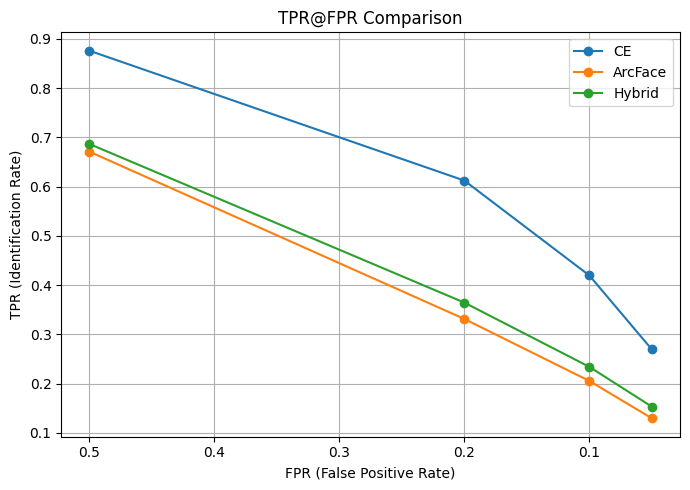

In [60]:
fpr_values = [0.5, 0.2, 0.1, 0.05]
plt.figure(figsize=(7, 5))

plt.plot(fpr_values, [float(v) for v in tprs_c], label="CE", marker='o')
plt.plot(fpr_values, [float(v) for v in tprs_a], label="ArcFace", marker='o')
plt.plot(fpr_values, [float(v) for v in tprs_h], label="Hybrid", marker='o')

plt.gca().invert_xaxis()
plt.xlabel("FPR (False Positive Rate)")
plt.ylabel("TPR (Identification Rate)")
plt.title("TPR@FPR Comparison")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [61]:
import matplotlib.pyplot as plt

def plot_threshold_vs_fpr(fpr_values, thresholds, model_name="Model"):
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_values, thresholds, marker='o', color='tab:red')
    plt.gca().invert_xaxis()

    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("Cosine similarity threshold")
    plt.title(f"Threshold vs FPR ({model_name})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


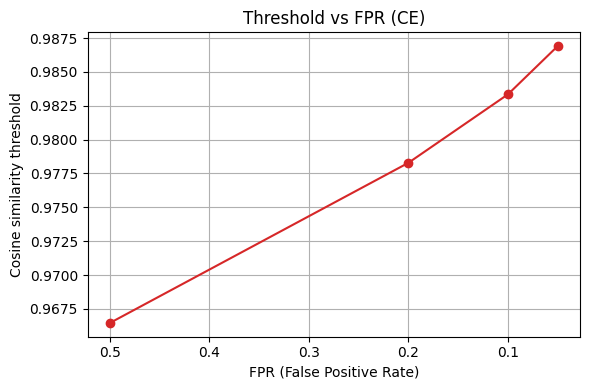

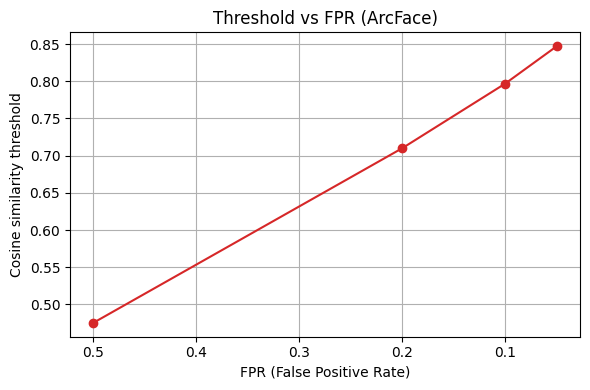

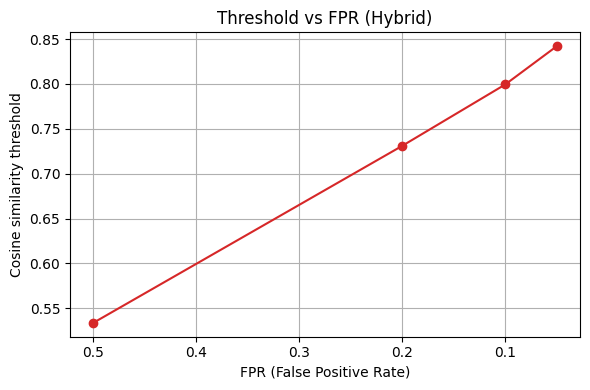

In [62]:
plot_threshold_vs_fpr([0.5, 0.2, 0.1, 0.05], thresholds_c, model_name="CE")
plot_threshold_vs_fpr([0.5, 0.2, 0.1, 0.05], thresholds_a, model_name="ArcFace")
plot_threshold_vs_fpr([0.5, 0.2, 0.1, 0.05], thresholds_h, model_name="Hybrid")